<a href="https://colab.research.google.com/github/dave-howard/PyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [29]:
import torch
from torch import nn  # neural networks
import matplotlib.pyplot as plt


In [30]:
torch.__version__

'2.1.0+cu121'

## 1. Data - preparing and loading

could be anything
- spreadheets
- videos
- images
- text
- audio

1. get data into numerical format
2. build a model to learn patterns in that numerical representation

We will use a linear regression formula - to make a stright line with known parameters - i.e. y = a + bx, where we know a and b

In [31]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # our input
# (unsqueeze to get one cell per row, which we need later)
y = X * weight + bias  # our output
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
len(X), len(y)

(50, 50)

In [33]:
# create a training (80%) and test (20%) set of data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [34]:
def plot_predictions(train_data=X_train, train_labels=y_train,
                     test_data=X_test, test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14})

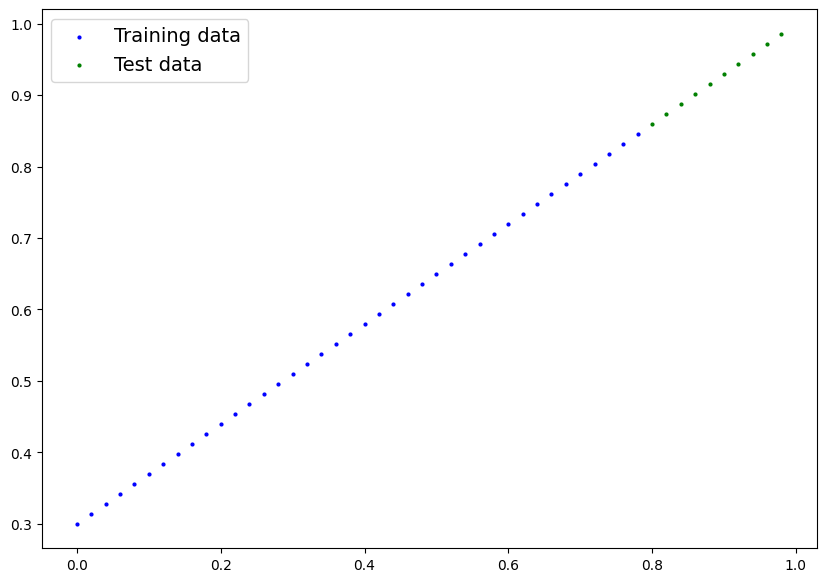

In [35]:
plot_predictions()

In [36]:
class LinearRegressionModel(nn.Module):
  """a PyTorch model - almost everything in PyTorch inherirts from nn.Module"""
  def __init__(self):
    super().__init__()
    # note: requires_grad - refers to 'gradient descent'
    # also something called backpropogation is used
    # Youtube - 3blue1brown has some good videos
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # forward method to define compuation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias  # the linear regression

In [37]:
torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float)

tensor([0.2345], requires_grad=True)

In [38]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [39]:
model_0.state_dict()  # get names of paramters

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [40]:
# the random param values should eventuially get to our preset weight/bias
weight, bias

(0.7, 0.3)

In [41]:
# see how well we can predict X_test based on y_test
print(f'X_test={X_test}\n\n')
with torch.inference_mode():  # inference mode means 'predicting' not 'learning'
# this is faster than running in default learning  mode
  y_preds = model_0(X_test)

print(f'y_preds={y_preds}\n\n')

X_test=tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])


y_preds=tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])




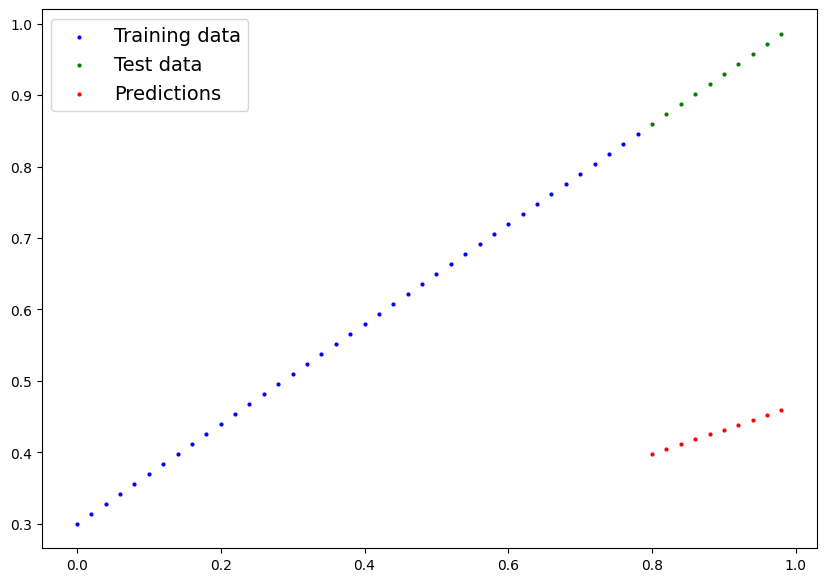

In [42]:
plot_predictions(predictions=y_preds)

## Training a Model
The idea of training a model is move from some unbknown/random parameters to some known parameters that better represent the desired output

We can use a __'Loss function'__ to determine how close or wrong a model/params is

Sometimes also known as a __'Cost function'__

There are loads of 'Loss funtcions' in `torch.nn`

In either case - a lower result means a closer match

__Optimizer__: adjusts the models parameters (weight and bias in this simple case)

For Pytorch we will need:
- a training loop
- a testing loop

In [43]:
# we will use torch.nn.l1Loss - which calculates the 'mean absolute error'
loss_fn = torch.nn.L1Loss()

# and a optimizer, and select an algorithm - https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer
# we will use 'Stochastic Gradient Descent' or SGD
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
# lr=learning rate VERY IMPORTANT HYPERPARAMETER - how much the parameters change each iteration
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Create a training loop

- loop through data to:
 - forward pass (data moving thnbrough our models `forward()` function)
 - calculate the 'loss' (compare predictions to actual data)
 - 'back propogate' - to calculate the gradients of each parameter
 - use the optimizer tro adjust model parameters

In [44]:
epochs = 200  # an epoch is one loop through the data
# number of epochs is a HYPERPARAMETER - as we have set it
epoch_values = []
loss_values = []
test_loss_values = []

# the TRAINING loop
for epoch in range(epochs):
  model_0.train() # sets gradients on all parameters
  y_pred = model_0(X_train)

  # calculate loss
  loss = loss_fn(y_pred, y_train)  # predictions versus expected from training data

  optimizer.zero_grad()  # what is this doing? prepare for next optimizer.step()

  loss.backward()  # backpropagation

  optimizer.step()
  # print(f'model state: {model_0.state_dict()}')

  ### Testing
  model_0.eval()  # switch off features for learning
  with torch.inference_mode():  # turn off gradient tracking
    test_pred = model_0(X_test)  # predict using the current model
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    epoch_values.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f'Epoch: {epoch} loss={loss} test_Loss={test_loss}')

# see how well we can predict X_test based on y_test
#print(f'X_test={X_test}\n\n')
with torch.inference_mode():  # inference mode means 'predicting' not 'learning'
# this is faster than running in default learning  mode
  y_preds = model_0(X_test)

#print(f'y_preds={y_preds}\n\n')
print(f'model state: {model_0.state_dict()} loss={loss}')

Epoch: 0 loss=0.31288138031959534 test_Loss=0.48106518387794495
Epoch: 100 loss=0.024458957836031914 test_Loss=0.05646304413676262
model state: OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]) loss=0.0025885067880153656


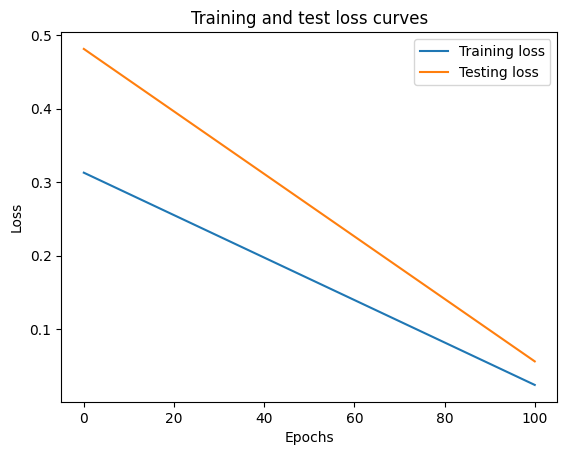

In [45]:
# plot the loss function
plt.plot(epoch_values, torch.tensor(loss_values).numpy(), label='Training loss')
plt.plot(epoch_values, test_loss_values, label='Testing loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();


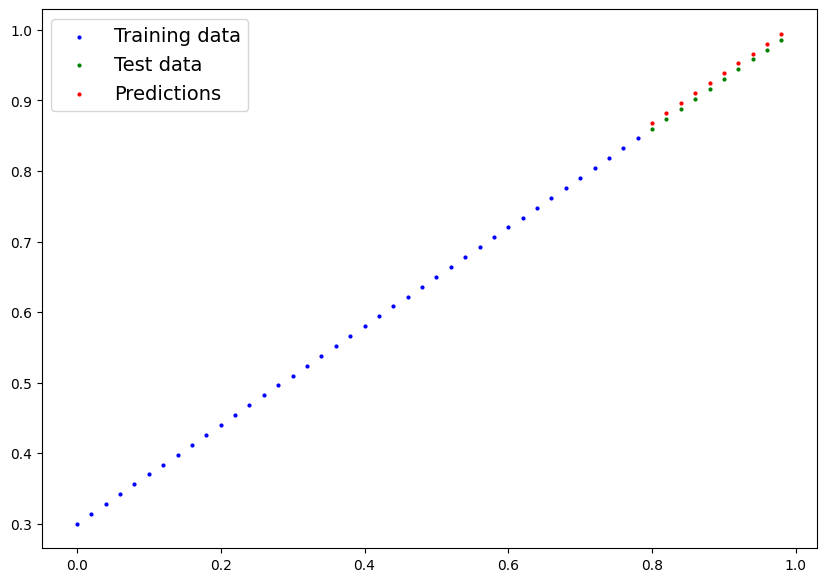

In [46]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  plot_predictions(predictions=y_preds_new)